# Transmission bottlenecks are stringent 

Date: originally drafted 2019-08-09, final draft edited 2020-01-15  
**Author**: Katarina Braun 


## Overview
- This script will evaluate the SNV frequencies at the timepoints closest to the time of transmission
- The first two plots will illustrate raw SNV frequency across each transmission event 
    - 4A: line plot of change in all HA SNV frequencies from index to contact 
    - 4B: JT/TV dot plot
- The third plot will employ the Koelle beta-binomial model to estimate the most likely size of each transmission bottleneck (Nb) 

**Colors**: (hex codes) 
1. **GD3 and recombinant viruses**: #264653
2. **Anhui**: #2A9D8F
3. **CA04**: #F4A261

## Input: 

This script uses the cleaned CSV files derived from the figure2 script:  
```H7N9-evolution-in-mammals/data_derived/SNVs/cleaned/*```

## Output: 

This script generates a plot and saves it here:    
`H7N9-evolution-in-mammals/figures/figure4.pdf`

All of the input text files to run the beta-binomial have already been generated (though code to do so is included here) and these files are saved here:    
`H7N9-evolution-in-mammals/data_derived/beta_binomial/*`

## for ease of use, here is a table summarizing the transmission pair available data 

### Index ferrets 

| Ferret ID | Virus | Day 1 | Day 3 | Day 5 | Day 7 |
| - | - | - | - | - | - |
|3|Guangdong/17SF003|x|x|x|x|
|9|R294-Guangdong|x|x|x|x|
|11|R294-Guangdong|x|x|
|15|R294-Guangdong|x|x|x|x|
|17|K294-Guangdong|x|x|x|x|
|21|K294-Guangdong|x|x|x|
|23|K294-Guangdong|x|x|x|x|
|27|Anhui1|x|x|x|x|
|35|CA04|x|x|x|

### Contact ferrets 

| Ferret ID | Virus | Day 3 | Day 5 | Day 7 | Day 9 | Day 11 | Day 13 | Day 15 |
| - | - | - | - | - | - | -|-|-|
|4|Guangdong/17SF003|-|x|x|x|x|
|10|R294-Guangdong|x|x|x|x|
|12|R294-Guangdong|x|x|
|16|R294-Guangdong|x|x|x|
|18|K294-Guangdong|-|-|-|-|x|x|x|
|22|K294-Guangdong|x|x|x|x|
|24|K294-Guangdong|
|28|Anhui1|x|x|x|
|36|CA04|x|x|

### Ferret pairs, timepoints closest to time of transmission 
| Ferret pair ID | Index ID | Contact ID | Virus | transmission timepoint #1 (index) | transmission timepoint #2 (contact) | 
| - | - | - | - | - | - | 
|1|3|4|Guangdong/17SF003|DPI 3| DPI 5|
|2|9|10|R294-Guangong|DPI 1| DPI 3|
|3|11|12|R294-Guangong|DPI 1| DPI 3|
|4|15|16|R294-Guangong|DPI 1| DPI 3|
|5|17|18|K294-Guangong|DPI 7| DPI 11|
|6|21|22|K294-Guangong|DPI 1| DPI 3|
|7|27|28|Anhui1|DPI 1| DPI 3|
|8|35|36|CA04|DPI 1| DPI 3|

### import modules and dependencies

In [117]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import os
import seaborn as sns; sns.set()
from matplotlib import pyplot
import matplotlib.pyplot as plt
from functools import reduce
import matplotlib as mpl
from matplotlib import gridspec
import itertools
import pysam
import matplotlib.patches as mpatches

### generate figure 4A: HA SNV frequencies over time 

### define function to load CSV with SNVs from each transmission pair into Pandas dataframes

In [104]:
def transmission_HA_SNVs(index, contact): 
    pair = []
    index = pd.read_csv(filepath_or_buffer='../data_derived/SNV/cleaned/' + index + '-cleaned.csv', header=0, sep='\t', low_memory=False)
    index = index[index.gene == 'HA']
    index = index[['SNP', '% of population']]
    pair.append(index)
    contact = pd.read_csv(filepath_or_buffer='../data_derived/SNV/cleaned/' + contact + '-cleaned.csv', header=0, sep='\t', low_memory=False)
    contact = contact[contact.gene == 'HA']
    contact = contact[['SNP', '% of population']]
    pair.append(contact)
    merged = reduce(lambda x, y: pd.merge(x, y, on='SNP', how='outer'), pair)
    merged = merged.fillna(0)
    merged_syn = merged.loc[merged['SNP'].str.contains("syn")]
    merged_nonsyn = merged.loc[~merged['SNP'].str.contains("syn")]
    return(merged_syn, merged_nonsyn) 

def transmission_SNVs(index, contact): 
    pair = []
    index = pd.read_csv(filepath_or_buffer='../data_derived/SNV/cleaned/' + index + '-cleaned.csv', header=0, sep='\t', low_memory=False)
    index = index[['SNP', '% of population']]
    pair.append(index)
    contact = pd.read_csv(filepath_or_buffer='../data_derived/SNV/cleaned/' + contact + '-cleaned.csv', header=0, sep='\t', low_memory=False)
    contact = contact[contact.gene == 'HA']
    contact = contact[['SNP', '% of population']]
    pair.append(contact)
    merged = reduce(lambda x, y: pd.merge(x, y, on='SNP', how='outer'), pair)
    merged = merged.fillna(0)
    merged_syn = merged.loc[merged['SNP'].str.contains("syn")]
    merged_nonsyn = merged.loc[~merged['SNP'].str.contains("syn")]
    return(merged_syn, merged_nonsyn) 
    

## For figure 4A (HA only)

In [105]:
# run transmission_HA_SNVs function on all transmisssion pairs and save each dataframe under its own name 
pair1 = transmission_HA_SNVs('GD3_ferret3_day3', 'GD3_ferret4_day5')
pair1_syn = pair1[0]
pair1_nonsyn = pair1[1]
pair2 = transmission_HA_SNVs('GD3_ferret9_day1', 'GD3_ferret10_day3')
pair2_syn = pair2[0]
pair2_nonsyn = pair2[1]
pair3 = transmission_HA_SNVs('GD3_ferret11_day1', 'GD3_ferret12_day3')
pair3_syn = pair3[0]
pair3_nonsyn = pair3[1]
pair4 = transmission_HA_SNVs('GD3_ferret15_day1', 'GD3_ferret16_day3')
pair4_syn = pair4[0]
pair4_nonsyn = pair4[1]
pair5 = transmission_HA_SNVs('GD3_ferret17_day7', 'GD3_ferret18_day11')
pair5_syn = pair5[0]
pair5_nonsyn = pair5[1]
pair6 = transmission_HA_SNVs('GD3_ferret21_day1', 'GD3_ferret22_day3')
pair6_syn = pair6[0]
pair6_nonsyn = pair6[1]
pair7 = transmission_HA_SNVs('Anhui_ferret27_day1', 'Anhui_ferret28_day3')
pair7_syn = pair7[0]
pair7_nonsyn = pair7[1]
pair8 = transmission_HA_SNVs('CA04_ferret35_day1', 'CA04_ferret36_day3')
pair8_syn = pair8[0]
pair8_nonsyn = pair8[1]

In [106]:
# concatenate virus groups (Anhui and CA04 don't need to be concatenated because there is only 1 transmission pair)
GD3_syn = pd.concat([pair1_syn, pair2_syn, pair3_syn, pair4_syn, pair5_syn, pair6_syn])
GD3_nonsyn = pd.concat([pair1_nonsyn, pair2_nonsyn, pair3_nonsyn, pair4_nonsyn, pair5_nonsyn, pair6_nonsyn])

Anhui_syn = pair7_syn
Anhui_nonsyn = pair7_nonsyn

CA04_syn = pair8_syn
CA04_nonsyn = pair8_nonsyn

In [107]:
# transpose dataframes to make plotting a bit easier -- this is for figure 4A 
GD3_syn_T = GD3_syn.T
GD3_syn_T.columns = GD3_syn_T.iloc[0]
GD3_syn_T = GD3_syn_T.drop(GD3_syn_T.index[0])
GD3_syn_T = GD3_syn_T.reset_index(drop=False)
GD3_nonsyn_T = GD3_nonsyn.T
GD3_nonsyn_T.columns = GD3_nonsyn_T.iloc[0]
GD3_nonsyn_T = GD3_nonsyn_T.drop(GD3_nonsyn_T.index[0])
GD3_nonsyn_T = GD3_nonsyn_T.reset_index(drop=False)

Anhui_syn_T = Anhui_syn.T
Anhui_syn_T.columns = Anhui_syn_T.iloc[0]
Anhui_syn_T = Anhui_syn_T.drop(Anhui_syn_T.index[0])
Anhui_syn_T = Anhui_syn_T.reset_index(drop=False)
Anhui_nonsyn_T = Anhui_nonsyn.T
Anhui_nonsyn_T.columns = Anhui_nonsyn_T.iloc[0]
Anhui_nonsyn_T = Anhui_nonsyn_T.drop(Anhui_nonsyn_T.index[0])
Anhui_nonsyn_T = Anhui_nonsyn_T.reset_index(drop=False)

CA04_syn_T = CA04_syn.T
CA04_syn_T.columns = CA04_syn_T.iloc[0]
CA04_syn_T = CA04_syn_T.drop(CA04_syn_T.index[0])
CA04_syn_T = CA04_syn_T.reset_index(drop=False)
CA04_nonsyn_T = CA04_nonsyn.T
CA04_nonsyn_T.columns = CA04_nonsyn_T.iloc[0]
CA04_nonsyn_T = CA04_nonsyn_T.drop(CA04_nonsyn_T.index[0])
CA04_nonsyn_T = CA04_nonsyn_T.reset_index(drop=False)

## For figure 4B (whole-genome only)

In [108]:
# run transmission_SNVs function on all transmisssion alls and save each dataframe under its own name 
all1 = transmission_SNVs('GD3_ferret3_day3', 'GD3_ferret4_day5')
all1_syn = all1[0]
all1_nonsyn = all1[1]
all2 = transmission_SNVs('GD3_ferret9_day1', 'GD3_ferret10_day3')
all2_syn = all2[0]
all2_nonsyn = all2[1]
all3 = transmission_SNVs('GD3_ferret11_day1', 'GD3_ferret12_day3')
all3_syn = all3[0]
all3_nonsyn = all3[1]
all4 = transmission_SNVs('GD3_ferret15_day1', 'GD3_ferret16_day3')
all4_syn = all4[0]
all4_nonsyn = all4[1]
all5 = transmission_SNVs('GD3_ferret17_day7', 'GD3_ferret18_day11')
all5_syn = all5[0]
all5_nonsyn = all5[1]
all6 = transmission_SNVs('GD3_ferret21_day1', 'GD3_ferret22_day3')
all6_syn = all6[0]
all6_nonsyn = all6[1]
all7 = transmission_SNVs('Anhui_ferret27_day1', 'Anhui_ferret28_day3')
all7_syn = all7[0]
all7_nonsyn = all7[1]
all8 = transmission_SNVs('CA04_ferret35_day1', 'CA04_ferret36_day3')
all8_syn = all8[0]
all8_nonsyn = all8[1]

In [109]:
# concatenate virus groups (Anhui and CA04 don't need to be concatenated because there is only 1 transmission all)
GD3_syn_all = pd.concat([all1_syn, all2_syn, all3_syn, all4_syn, all5_syn, all6_syn])
GD3_nonsyn_all = pd.concat([all1_nonsyn, all2_nonsyn, all3_nonsyn, all4_nonsyn, all5_nonsyn, all6_nonsyn])

Anhui_syn_all = all7_syn
Anhui_nonsyn_all = all7_nonsyn

CA04_syn_all = all8_syn
CA04_nonsyn_all = all8_nonsyn

In [110]:
# GD3 
GD3_syn_all_B = GD3_syn_all.rename(columns={'% of population_x': 'x', '% of population_y': 'y'})
GD3_syn_all_B['facecolors'] = 'none'
GD3_syn_all_B['edgecolors'] = '#08367F'
GD3_nonsyn_all_B = GD3_nonsyn_all.rename(columns={'% of population_x': 'x', '% of population_y': 'y'})
GD3_nonsyn_all_B['facecolors'] = '#08367F'
GD3_nonsyn_all_B['edgecolors'] = '#08367F'

# Anhui 
Anhui_syn_all_B = Anhui_syn_all.rename(columns={'% of population_x': 'x', '% of population_y': 'y'})
Anhui_syn_all_B['facecolors'] = 'none'
Anhui_syn_all_B['edgecolors'] = '#2A9D8F'
Anhui_nonsyn_all_B = Anhui_nonsyn_all.rename(columns={'% of population_x': 'x', '% of population_y': 'y'})
Anhui_nonsyn_all_B['facecolors'] = '#2A9D8F'
Anhui_nonsyn_all_B['edgecolors'] = '#2A9D8F'

# CA04 
CA04_syn_all_B = CA04_syn_all.rename(columns={'% of population_x': 'x', '% of population_y': 'y'})
CA04_syn_all_B['facecolors'] = 'none'
CA04_syn_all_B['edgecolors'] = '#F4A261'
CA04_nonsyn_all_B = CA04_nonsyn_all.rename(columns={'% of population_x': 'x', '% of population_y': 'y'})
CA04_nonsyn_all_B['facecolors'] = '#F4A261'
CA04_nonsyn_all_B['edgecolors'] = '#F4A261'

# concatenate all above dataframes
DF_for_4B = pd.concat([GD3_syn_all_B, GD3_nonsyn_all_B, Anhui_syn_all_B, Anhui_nonsyn_all_B, CA04_syn_all_B, CA04_nonsyn_all_B])
# DF_for_4B.to_csv('../data_derived/SNV/DF_for_4B.csv', sep='\t') # uncomment to save this dataframe to the data_derived directory

## For figure 4C (beta-binomial model) 

#### Generate files to go into the Koelle beta-binomial model to estimate transmission bottleneck sizes using SNP frequencies in index and donors 

syntax:  
index = donor
contact = recipient 

**Notes from Katia Koelle regarding this model:**   
Assumptions about what SNPs are de novo vs transmitted make a huge difference. Since in our JVI paper we analyzed the contaminated Poon et al. data with a lot of within-host genetic diversity present, this didn't matter for our bottleneck estimates, but given that genetic diversity levels are actually really low within hosts, whether you assume an observed SNP is transmitted or arises de novo actually will make a big difference now.

1. If a SNP is observed at a frequency that indicates that it is likely fixed in a donor (i.e., that site is monomorphic in the donor), it shouldn't be included in the analysis, regardless of whether that site is polymorphic in the recipient.  


2. If a site is polymorphic in a donor (i.e., a SNP is present at a level that indicates that it is present but not fixed), it should be included in the analysis (regardless of whether the site is monomorphic or polymorphic in the recipient)  
    
    
    - A site being polymorphic (with a SNP being at high levels of ~50%) in the donor, and monomorphic in the recipient is an indication of a small bottleneck.  
    - A site being monomorphic in the donor, and polymorphic (especially at high SNP frequencies) in the recipient is also a strong indication of a small bottleneck. The more of these you see, the smaller the bottleneck likely is (assuming, that is, that you correctly identified a transmission pair)  
    
    
3. If your limit of detection is X, then any SNP below X or above 1-X should be considered fixed. (This is consistent with what McCrone does.) In my code, I assume that the input data for the donor consists ONLY of sites that are polymorphic (ie.. have SNPs that have values between X and 1-X), and the corresponding frequencies at those sites in the recipient. If the frequency at a given site in the recipient is below X or above 1-X, it shouldn't matter whether you set it to being fixed (i.e., set it to 0 or 1, respectively), or keep it at that observed value, of, for example, 0.005 or 0.995. Not 100% sure what Tyler Smith's R code assumes, so to be safe, you can set the frequencies at those recipient sites to 0 or 1 (depending on whether the SNP frequency is below X or above 1-X, respectively).  


4. Should I be including SNPs which are not present in the index but are present in the contact? --> No. These are very likely de novo variants. Their presence in your data indicate, however, that bottleneck sizes would be small.  


We assume that a SNP that is not observed in a recipient but present (but not fixed) in a donor can be either truly absent in the recipient, or present in the recipient only below the limit of detection.

**File that needs to be generated, input to beta-binomial model**:   
Column 1: frequency of SNP in index/donor  
Column 2: frequency of SNP in contact/recipient  
Column 3: total recipient reads --> I think this is "AD" in averaged VCF files  
Column 4: variant recipient reads --> I think this is "DP" in the average VCF files 

File type: `.txt`

Use 6 decimal positions for frequencies and read numbers.  
Separator = tab. 

Writing output files to this directory:     
`H7N9-evolution-in-mammals/data_derived/beta_binomial/*`

Plug these files into this R script, located here:   
`H7N9-evolution-in-mammals/data_derived/beta_binomial/BB_bottleneck-master/Bottleneck_size_estimation_exact.r`

syntax to run the exact model:   
```bash 
Rscript Bottleneck_size_estimation_exact.r --file pair2_beta-binomial-input.txt --plot_bool TRUE --var_calling_threshold 0.01 --Nb_min 1 --Nb_max 200 --confidence_level 0.99
```
** this script is easiest to run from the directory where the script and the input files are located

In [111]:
# this is function to get average read counts at each position 
def getReadDepth(bamfile, segment, pos):
    sam = pysam.AlignmentFile(bamfile, "rb")
    pileup = sam.pileup(contig=segment, start=pos-1, end=pos, truncate=True, stepper="nofilter")
    column = next(pileup)
    column.set_min_base_quality(30)
    return column.get_num_aligned()

This code modifies raw VCF files to generate input files required for the beta-binomial model. 
This does not need to be run because the output files are already generated and saved in ```data_derived/beta_binomial/*```. 

```Python
index_num = pd.read_csv(filepath_or_buffer='../data_derived/SNV/' + index + '_averaged.vcf', header=0, sep='\t', low_memory=False)
index_num = index_num.drop(['#CHROM', 'ID', 'QUAL', 'FILTER', 'INFO', 'FORMAT'], axis=1) # drop columns that aren't needed
index_num['AAchange'] = index_num['AAchange'].replace({'.':'syn'}) # replace the period=synonymous with "syn" for clarity 
index_num['gene'] = index_num['gene'].replace({'NA gene':'NA'})
index_num['SNP'] = index_num['gene'] + '_' + index_num['REF'] + index_num['POS'].map(str) + index_num['ALT'] + '_' + index_num['AAchange'] # create new column with GENE_REF-POS-ALT = SNP
index_num = index_num[~index_num['AAchange'].astype(str).str.contains('not in ORF')]# delete rows in the dataframe that contain "not in ORF" -- I don't need to track these SNPs
index_num = index_num[['SNP', 'FREQ']] # reorder the columns to make a little more sense and rename FREQ to specify index
index_num.rename(columns={'FREQ':'FREQ_index'}, inplace=True)
index_num = index_num[['SNP', 'FREQ_index']]

contact_num = pd.read_csv(filepath_or_buffer='../data_derived/SNV/' + contact + '_averaged.vcf', header=0, sep='\t', low_memory=False)
contact_num = contact_num.drop(['#CHROM', 'ID', 'QUAL', 'FILTER', 'INFO', 'FORMAT'], axis=1) # drop columns that aren't needed
contact_num['AAchange'] = contact_num['AAchange'].replace({'.':'syn'}) # replace the period=synonymous with "syn" for clarity
contact_num['SNP'] = contact_num['gene'] + '_' + contact_num['REF'] + contact_num['POS'].map(str) + contact_num['ALT'] + '_' + contact_num['AAchange'] # create new column with GENE_REF-POS-ALT = SNP
contact_num = contact_num[~contact_num['AAchange'].astype(str).str.contains('not in ORF')] # delete rows in the dataframe that contain "not in ORF" -- I don't need to track these SNPs
contact_num = contact_num[['gene', 'POS', 'REF', 'ALT', 'FREQ', 'SNP', contact]] # reorder the columns to make a little more sense
contact_num[['GT', 'GQ', 'SDP', 'DP', 'RD', 'AD', 'FREQ', 'PVAL', 'RBQ','ABQ']] = contact_num[contact].str.split(':', expand=True)
contact_num = contact_num.drop(['GT', 'GQ', 'SDP', 'RD', 'PVAL', 'RBQ', 'ABQ', contact], axis=1)
contact_num.rename(columns={'DP':'total_reads_contact', 'AD':'variant_reads_contact', 'FREQ':'FREQ_contact'}, inplace=True)
contact_num = contact_num[['SNP', 'FREQ_contact', 'total_reads_contact', 'variant_reads_contact']]

BB_num = pd.merge(index_num, contact_num, how='outer', on=['SNP'])
BB_num = BB_num.replace(np.nan, 0)
tolist_num = BB_num.loc[BB_num['total_reads_contact'] == 0]
tolist_num = num_tolist.drop(['FREQ_index', 'FREQ_contact', 'total_reads_contact', 'variant_reads_contact'], axis=1)
tolist_num[['gene', 'pos', 'annotation']] = tolist_num['SNP'].str.split('_', expand=True)
tolist_num = tolist_num.drop(['annotation'], axis=1)
tolist_num['pos'] = tolist_num['pos'].str.extract('(\d+)').astype(int)
contact_SNP_num = {k: g["pos"].tolist() for k,g in tolist_num.groupby("gene")}
```

Below is the code I used to sort the bam file in order to use the function above.   
This does not need to be run because the sorted bam files are already saved in ```data_derived/transmission_bams/sorted```.   

```bash

bam_rep1="../data_derived/transmission_bams/CA04_ferret36_day3_rep1.bam"
bam_rep2="../data_derived/transmission_bams/CA04_ferret36_day3_rep2.bam"
sorted_bam_rep1="../data_derived/transmission_bams/sorted/CA04_ferret36_day3_rep1-sorted.bam"
sorted_bam_rep2="../data_derived/transmission_bams/sorted/CA04_ferret36_day3_rep2-sorted.bam"

samtools sort -o $sorted_bam_rep1 $bam_rep1
samtools index $sorted_bam_rep1
samtools sort -o $sorted_bam_rep2 $bam_rep2
samtools index $sorted_bam_rep2
```


Below is the rest of code I used to generate input files for the beta-binomial exact code:   
(substituting the correct ferret ID and timepoint for each #FERRETID_TIMEID# indicated) 

The files generated from running this code as well as the exact binomial plots can all be found in 
```data_derived/beta_binomial/*``` and are labeled according to transmission pair. 

```python
index_num = pd.read_csv(filepath_or_buffer='../data_derived/SNV/#FERRETID_TIMEID#.vcf', header=0, sep='\t', low_memory=False)
index_num = index_num.drop(['#CHROM', 'ID', 'QUAL', 'FILTER', 'INFO', 'FORMAT'], axis=1) # drop columns that aren't needed
index_num['AAchange'] = index_num['AAchange'].replace({'.':'syn'}) # replace the period=synonymous with "syn" for clarity 
index_num['gene'] = index_num['gene'].replace({'NA gene':'NA'})
index_num['SNP'] = index_num['gene'] + '_' + index_num['REF'] + index_num['POS'].map(str) + index_num['ALT'] + '_' + index_num['AAchange'] # create new column with GENE_REF-POS-ALT = SNP
index_num = index_num[~index_num['AAchange'].astype(str).str.contains('not in ORF')]# delete rows in the dataframe that contain "not in ORF" -- I don't need to track these SNPs
index_num = index_num[['SNP', 'FREQ']] # reorder the columns to make a little more sense and rename FREQ to specify index
index_num.rename(columns={'FREQ':'FREQ_index'}, inplace=True)
index_num = index_num[['SNP', 'FREQ_index']]

contact_num = pd.read_csv(filepath_or_buffer='../data_derived/SNV/#FERRETID_TIMEID#.vcf, header=0, sep='\t', low_memory=False)
contact_num = contact_num.drop(['#CHROM', 'ID', 'QUAL', 'FILTER', 'INFO', 'FORMAT'], axis=1) # drop columns that aren't needed
contact_num['AAchange'] = contact_num['AAchange'].replace({'.':'syn'}) # replace the period=synonymous with "syn" for clarity
contact_num['SNP'] = contact_num['gene'] + '_' + contact_num['REF'] + contact_num['POS'].map(str) + contact_num['ALT'] + '_' + contact_num['AAchange'] # create new column with GENE_REF-POS-ALT = SNP
contact_num = contact_num[~contact_num['AAchange'].astype(str).str.contains('not in ORF')] # delete rows in the dataframe that contain "not in ORF" -- I don't need to track these SNPs
contact_num = contact_num[['gene', 'POS', 'REF', 'ALT', 'FREQ', 'SNP', #FERRETID_TIMEID#]] # reorder the columns to make a little more sense
contact_num[['GT', 'GQ', 'SDP', 'DP', 'RD', 'AD', 'FREQ', 'PVAL', 'RBQ','ABQ']] = contact_num[#FERRETID_TIMEID#].str.split(':', expand=True)
contact_num = contact_num.drop(['GT', 'GQ', 'SDP', 'RD', 'PVAL', 'RBQ', 'ABQ', #FERRETID_TIMEID#], axis=1)
contact_num.rename(columns={'DP':'total_reads_contact', 'AD':'variant_reads_contact', 'FREQ':'FREQ_contact'}, inplace=True)
contact_num = contact_num[['SNP', 'FREQ_contact', 'total_reads_contact', 'variant_reads_contact']]

BB_num = pd.merge(index_num, contact_num, how='outer', on=['SNP'])
BB_num = BB_num.replace(np.nan, 0)
tolist_num = BB_num.loc[BB_num['total_reads_contact'] == 0]
tolist_num = tolist_num.drop(['FREQ_index', 'FREQ_contact', 'total_reads_contact', 'variant_reads_contact'], axis=1)
tolist_num[['gene', 'pos', 'annotation']] = tolist_num['SNP'].str.split('_', expand=True)
tolist_num = tolist_num.drop(['annotation'], axis=1)
tolist_num['pos'] = tolist_num['pos'].str.extract('(\d+)').astype(int)
contact_SNP_DP = {k: g["pos"].tolist() for k,g in tolist_num.groupby("gene")}f
                                
# getting the correct entries for column 3 is going to be a little tricky 
# I have to do is go back to the normalized BAM files and extract DP = average read depth at each position 
sorted_bam_num_rep1="../data_derived/transmission_bams/sorted/#FERRETID_TIMEID#_rep1-sorted.bam"
sorted_bam_num_rep2="../data_derived/transmission_bams/sorted/#FERRETID_TIMEID#_rep2-sorted.bam"

# apply the getReadDepth function to the dataframe DF_tolist slice, which contains
# the rows that need to have the total_reads_contact column updated 
# tolist_num['gene'] = tolist_num['gene'].replace({'PB2':'A_GUANGDONG_17SF003_2016_PB2', 'PB1':'A_GUANGDONG_17SF003_2016_PB1', 'PA':'A_GUANGDONG_17SF003_2016_PA', 'HA':'A_GUANGDONG_17SF003_2016_H7', 'NP':'A_GUANGDONG_17SF003_2016_NP', 'NA':'A_GUANGDONG_17SF003_2016_N9', 'M1':'A_GUANGDONG_17SF003_2016_MP', 'M2':'A_GUANGDONG_17SF003_2016_MP', 'NS1':'A_GUANGDONG_17SF003_2016_NS', 'NEP':'A_GUANGDONG_17SF003_2016_NS'})
# tolist_num['gene'] = tolist_num['gene'].replace({'PB2':'A_ANHUI_1_2013_PB2', 'PB1':'A_ANHUI_1_2013_PB1', 'PA':'A_ANHUI_1_2013_PA', 'HA':'A_ANHUI_1_2013_H7', 'NP':'A_ANHUI_1_2013_NP', 'NA':'A_ANHUI_1_2013_N9', 'M1':'A_ANHUI_1_2013_MP', 'M2':'A_ANHUI_1_2013_MP', 'NS1':'A_ANHUI_1_2013_NS', 'NEP':'A_ANHUI_1_2013_NS'})
# tolist_num['gene'] = tolist_num['gene'].replace({'PB2':'A_CALIFORNIA_04_2009_PB2', 'PB1':'A_CALIFORNIA_04_2009_PB1', 'PA':'A_CALIFORNIA_04_2009_PA', 'HA':'A_CALIFORNIA_04_2009_H1', 'NP':'A_CALIFORNIA_04_2009_NP', 'NA':'A_CALIFORNIA_04_2009_N1', 'M1':'A_CALIFORNIA_04_2009_MP', 'M2':'A_CALIFORNIA_04_2009_MP', 'NS1':'A_CALIFORNIA_04_2009_NS', 'NEP':'A_CALIFORNIA_04_2009_NS'})
tolist_num['total_reads_contact_1'] = tolist_num.apply(lambda x:getReadDepth(sorted_bam_num_rep1, x['gene'], x['pos']), axis=1)
tolist_num['total_reads_contact_2'] = tolist_num.apply(lambda x:getReadDepth(sorted_bam_num_rep2, x['gene'], x['pos']), axis=1)

                                # average total_read_contact replicates
tolist_num['total_reads_contact'] = tolist_num[['total_reads_contact_1', 'total_reads_contact_2']].mean(axis=1)
contactDP_num = tolist_num.drop(['gene', 'total_reads_contact_1', 'total_reads_contact_2', 'pos'], axis=1)

# update DF_BB with values in total_reads_contact from contactDP_num
DF_final_num = contactDP_num.combine_first(BB_num).reindex(BB_num.index)
DF_final_num = DF_final_num[['SNP', 'FREQ_index', 'FREQ_contact', 'total_reads_contact', 'variant_reads_contact']]

# drop rows where FREQ_index = 0 and FREQ_contact != 0 because these rows are likely 
# de novo variants and the beta-binomial model doesn't incorporate these yet 
DF_final_num = DF_final_num[DF_final_num.FREQ_index != 0]
DF_final_noSNPs_num = DF_final_num.drop(['SNP'], axis=1)

# convert anything >0.99 to 0.999999 (assumed to be fixed) 
DF_final_noSNPs_num['FREQ_contact'] = np.where(DF_final_noSNPs_num['FREQ_contact']>=0.99, 0.999999, DF_final_noSNPs_num['FREQ_contact'])

# convert to string
DF_final_noSNPs_num = DF_final_noSNPs_num.astype(str)

# convert to 6 decimal positions 
DF_final_noSNPs_num['FREQ_index'] = DF_final_noSNPs_num['FREQ_index'].apply(lambda x: '{0:0<8}'.format(x))
DF_final_noSNPs_num['FREQ_contact'] = DF_final_noSNPs_num['FREQ_contact'].apply(lambda x: '{0:0<8}'.format(x))
DF_final_noSNPs_num['total_reads_contact'] = DF_final_noSNPs_num['total_reads_contact'].apply(lambda x: '{0:0<11}'.format(x))
DF_final_noSNPs_num['variant_reads_contact'] = DF_final_noSNPs_num['variant_reads_contact'].apply(lambda x: '{0:0<8}'.format(x))

# can't figure out how to adjust decimals -- might have to do this by hand in VS studio or Excel
# this is easy to do in excel 
# ALSO IMPORTANT -- exclude  all sites that are monomorphic (fixed) in the donor

# save to text file 
DF_final_noSNPs_num.to_csv('../data_derived/beta_binomial/pair#NUM#_beta-binomial-input.txt', sep='\t', header=None, index=False)
                                
```

Here is the syntax I used to run the exact beta-binomial model (from the terminal) with the output generated in the command line. 

#### Pair 1: ferrets 3 (day 3) and 4 (day 5), GD3. 

```bash 

Rscript Bottleneck_size_estimation_exact.r --file pair1_beta-binomial-input.txt --plot_bool TRUE --var_calling_threshold 0.01 --Nb_min 1 --Nb_max 200 --confidence_level 0.99
```

**Output**:   
[1] "Bottleneck size"  
[1] 2  
[1] "confidence interval left bound"  
[1] 1  
[1] "confidence interval right bound"  
[1] 3 

#### Pair 2: ferrets 9 (day 1) and 10 (day 3), GD3. 

```bash 

Rscript Bottleneck_size_estimation_exact.r --file pair2_beta-binomial-input.txt --plot_bool TRUE --var_calling_threshold 0.01 --Nb_min 1 --Nb_max 200 --confidence_level 0.99
```

**Output**:   
[1] "Bottleneck size"  
[1] 1  
[1] "confidence interval left bound"  
[1] 0  
[1] "confidence interval right bound"  
[1] 2  

#### Pair 3: ferrets 11 (day 1) and 12 (day 3), GD3. 

```bash 

Rscript Bottleneck_size_estimation_exact.r --file pair3_beta-binomial-input.txt --plot_bool TRUE --var_calling_threshold 0.01 --Nb_min 1 --Nb_max 200 --confidence_level 0.99
```

**Output**:   
[1] "Bottleneck size"  
[1] 1  
[1] "confidence interval left bound"  
[1] 0  
[1] "confidence interval right bound"  
[1] 2 

#### Pair 4: ferrets 15 (day 1) and 16 (day 3), GD3. 

```bash 

Rscript Bottleneck_size_estimation_exact.r --file pair4_beta-binomial-input.txt --plot_bool TRUE --var_calling_threshold 0.01 --Nb_min 1 --Nb_max 200 --confidence_level 0.99
```

**Output**:   
[1] "Bottleneck size"  
[1] 1  
[1] "confidence interval left bound"  
[1] 0  
[1] "confidence interval right bound"  
[1] 2 

#### Pair 5: ferrets 17 (day 7) and 18 (day 11), GD3. 

```bash 

Rscript Bottleneck_size_estimation_exact.r --file pair5_beta-binomial-input.txt --plot_bool TRUE --var_calling_threshold 0.01 --Nb_min 1 --Nb_max 200 --confidence_level 0.99
```

**Output**:   
[1] "Bottleneck size"  
[1] 1  
[1] "confidence interval left bound"  
[1] 0  
[1] "confidence interval right bound"  
[1] 2 

#### Pair 6: ferrets 21 (day 1) and 22 (day 3), GD3. 

```bash 

Rscript Bottleneck_size_estimation_exact.r --file pair6_beta-binomial-input.txt --plot_bool TRUE --var_calling_threshold 0.01 --Nb_min 1 --Nb_max 200 --confidence_level 0.99
```

**Output**:   
[1] "Bottleneck size"  
[1] 1  
[1] "confidence interval left bound"  
[1] 0  
[1] "confidence interval right bound"  
[1] 2 

#### Pair 7: ferrets 27 (day 1) and 28 (day 3), Anhui. 

```bash 

Rscript Bottleneck_size_estimation_exact.r --file pair7_beta-binomial-input.txt --plot_bool TRUE --var_calling_threshold 0.01 --Nb_min 1 --Nb_max 200 --confidence_level 0.99
```

**Output**:   
[1] "Bottleneck size"  
[1] 1  
[1] "confidence interval left bound"  
[1] 0  
[1] "confidence interval right bound"  
[1] 2 

#### Pair 8: ferrets 35 (day 1) and 36 (day 3), CA04. 

```bash 

Rscript Bottleneck_size_estimation_exact.r --file pair8_beta-binomial-input.txt --plot_bool TRUE --var_calling_threshold 0.01 --Nb_min 1 --Nb_max 200 --confidence_level 0.99
```

**Output**:   
[1] "Bottleneck size"  
[1] 4  
[1] "confidence interval left bound"  
[1] 1  
[1] "confidence interval right bound"  
[1] 11 

In [113]:
# this code will combine the GD3 dataframes so I can run the beta-binomial model on all GD3 transmission events 
one = pd.read_csv('../data_derived/beta_binomial/pair1_beta-binomial-input.txt', sep='\t', names=['FREQ_index', 'FREQ_contact', 'total_reads_contact', 'variant_reads_contact'])
two = pd.read_csv('../data_derived/beta_binomial/pair2_beta-binomial-input.txt', sep='\t', names=['FREQ_index', 'FREQ_contact', 'total_reads_contact', 'variant_reads_contact'])
three = pd.read_csv('../data_derived/beta_binomial/pair3_beta-binomial-input.txt', sep='\t', names=['FREQ_index', 'FREQ_contact', 'total_reads_contact', 'variant_reads_contact'])
four = pd.read_csv('../data_derived/beta_binomial/pair4_beta-binomial-input.txt', sep='\t', names=['FREQ_index', 'FREQ_contact', 'total_reads_contact', 'variant_reads_contact'])
five = pd.read_csv('../data_derived/beta_binomial/pair5_beta-binomial-input.txt', sep='\t', names=['FREQ_index', 'FREQ_contact', 'total_reads_contact', 'variant_reads_contact'])
six = pd.read_csv('../data_derived/beta_binomial/pair6_beta-binomial-input.txt', sep='\t', names=['FREQ_index', 'FREQ_contact', 'total_reads_contact', 'variant_reads_contact'])
seven = pd.read_csv('../data_derived/beta_binomial/pair7_beta-binomial-input.txt', sep='\t', names=['FREQ_index', 'FREQ_contact', 'total_reads_contact', 'variant_reads_contact'])
eight = pd.read_csv('../data_derived/beta_binomial/pair8_beta-binomial-input.txt', sep='\t', names=['FREQ_index', 'FREQ_contact', 'total_reads_contact', 'variant_reads_contact'])

GD3 = pd.concat([one, two, three, four, five, six], axis=0)
all_pairs = pd.concat([one, two, three, four, five, six, seven, eight], axis=0)

# save these concatenated dataframes to text files 
GD3.to_csv('../data_derived/beta_binomial/GD3_beta-binomial-input.txt', sep='\t', header=None, index=False)
all_pairs.to_csv('../data_derived/beta_binomial/all_beta-binomial-input.txt', sep='\t', header=None, index=False)

Here is the syntax I used to run the exact beta-binomial model (from the terminal) with the output generated in the command line **on combinations of transmission events**: 
- all GD3 transmissions (1-6) 
- all transmission (1-8)

#### All GD3 transmission events (pairs 1 - 6)

```bash 

Rscript Bottleneck_size_estimation_exact.r --file GD3_beta-binomial-input.txt --plot_bool TRUE --var_calling_threshold 0.01 --Nb_min 1 --Nb_max 200 --confidence_level 0.99
```

**Output**:   
[1] "Bottleneck size"  
[1] 2  
[1] "confidence interval left bound"  
[1] 1  
[1] "confidence interval right bound"  
[1] 3 

#### All transmission events (pairs 1 - 8)

```bash 

Rscript Bottleneck_size_estimation_exact.r --file all_beta-binomial-input.txt --plot_bool TRUE --var_calling_threshold 0.01 --Nb_min 1 --Nb_max 200 --confidence_level 0.99
```

**Output**:   
[1] "Bottleneck size"  
[1] 2  
[1] "confidence interval left bound"  
[1] 1  
[1] "confidence interval right bound"  
[1] 3 

### generate figure 4 

/Users/katbraun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


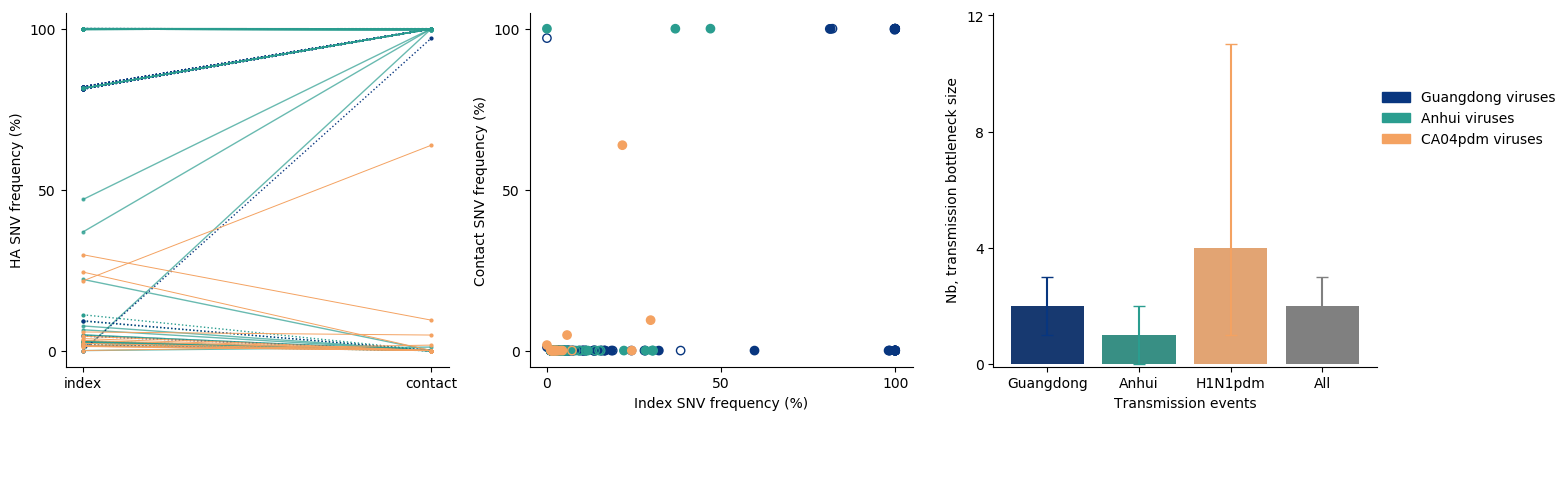

In [141]:
# define hex colors
GD3 = '#08367F'
Anhui = '#2A9D8F'
CA04 = '#F4A261'

# generate a figure with sub-plots (one for each gene segment)
fig4 = plt.figure(figsize=(14,8), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Helvetica')
gs = gridspec.GridSpec(2, 12)

ax1 = fig4.add_subplot(gs[0,0:4]) # SNV frequencies 
ax2 = fig4.add_subplot(gs[0,4:8]) # JT/TV plot
ax3 = fig4.add_subplot(gs[0,8:12]) # beta-binomial estimates 

# create a marker palette
marker = itertools.cycle(('.', 'v', '^', '<', '>', 'p', '+', '*', 'x', 'X', 'D', 'd', '|', '1', '2', '3', '4', 's', 'h', 'H')) 

# get right of top and right frame of each subplot
axes = (ax1, ax2, ax3)
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    
# set fontsize of axes 
ax = plt.gca()
for ax in axes: 
    ax.tick_params(axis = 'both', which = 'major', labelsize = 10)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = 10)

# FOR PLOT 4A
# plot Anhui synonymous lines  
num=0
for column in Anhui_syn_T.drop('index', axis=1):
    num+=1
    ax1.plot(Anhui_syn_T['index'], Anhui_syn_T[column], marker='.', markersize=4, color=Anhui, linewidth=1, alpha=1, label=column, linestyle='dotted')

# plot Anhui synonymous lines  
num=0
for column in Anhui_nonsyn_T.drop('index', axis=1):
    num+=1
    ax1.plot(Anhui_nonsyn_T['index'], Anhui_nonsyn_T[column], marker='.', markersize=4, color=Anhui, linewidth=1, alpha=0.7, label=column)
    
# plot GD3 synonymous lines  
num=0
for column in GD3_syn_T.drop('index', axis=1):
    num+=1
    ax1.plot(GD3_syn_T['index'], GD3_syn_T[column], marker='.', markersize=4, color=GD3, linewidth=1, alpha=1, label=column, linestyle='dotted')

# plot GD3 synonymous lines  
num=0
for column in GD3_nonsyn_T.drop('index', axis=1):
    num+=1
    ax1.plot(GD3_nonsyn_T['index'], GD3_nonsyn_T[column], marker='.', markersize=4, color=Anhui, linewidth=1, alpha=0.7, label=column)

# plot CA04 synonymous lines  
num=0
for column in CA04_syn_T.drop('index', axis=1):
    num+=1
    ax1.plot(CA04_syn_T['index'], CA04_syn_T[column], marker='.', markersize=4, color=CA04, linewidth=1, alpha=1, label=column, linestyle='dotted')

# plot GD3 synonymous lines  
num=0
for column in CA04_nonsyn_T.drop('index', axis=1):
    num+=1
    ax1.plot(CA04_nonsyn_T['index'], CA04_nonsyn_T[column], marker='.', markersize=4, color=CA04, linewidth=0.7, alpha=1, label=column)

# edit the axes - ax1
ax1.set_title('', fontname='Helvetica', fontsize=14)
ax1.set_ylabel('HA SNV frequency (%)', fontname='Helvetica', fontsize=10)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Helvetica")
ax1.set_ylim(-5,105)
ax1.set_yticks([0,50,100])
ax1.set_xlim(-0.05,1.05)
ax1.set_xticklabels(['index', 'contact'], fontname='Helvetica', fontsize='10', minor=False)
    
# FOR PLOT 4B 
ax2.scatter(DF_for_4B.x, DF_for_4B.y, facecolor=DF_for_4B.facecolors, edgecolor=DF_for_4B.edgecolors)

# edit the axes - ax2
ax2.set_title('', fontname='Helvetica', fontsize=14)
ax2.set_ylabel('Contact SNV frequency (%)', fontname='Helvetica', fontsize=10)
ax2.set_xlabel('Index SNV frequency (%)', fontname='Helvetica', fontsize=10)
ax2.set_facecolor('white')
for tick in ax2.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax2.get_yticklabels():
    tick.set_fontname("Helvetica")
ax2.set_ylim(-5,105)
ax2.set_yticks([0,50,100])
ax2.set_xlim(-5,105)
ax2.set_xticks([0,50,100])

# FOR PLOT 4C 
# these values for the bottleneck size (Nb) as well as left and right confidence intervals 
# are pulled from the cells above, which document the output from the exact beta-binomial model
BB = pd.DataFrame({"":['Guangdong', 'Anhui', 'H1N1pdm', 'All'], "Nb":[2,1,4,2], "CI-left":[1,0,1,1], "CI-right":[3,2,11,3]})
BB_GD3 = BB.loc[[0]]
BB_anhui = BB.loc[[1]]
BB_CA04 = BB.loc[[2]]
BB_all = BB.loc[[3]]

#bottom error, then top 
yerr_GD3 = [BB_GD3['Nb'] - BB_GD3['CI-left'], BB_GD3['CI-right'] - BB_GD3['Nb']]
yerr_anhui = [BB_anhui['Nb'] - BB_anhui['CI-left'], BB_anhui['CI-right'] - BB_anhui['Nb']]
yerr_CA04 = [BB_CA04['Nb'] - BB_CA04['CI-left'], BB_CA04['CI-right'] - BB_CA04['Nb']]
yerr_all = [BB_all['Nb'] - BB_all['CI-left'], BB_all['CI-right'] - BB_all['Nb']]

# axes
flatui = ['#08367F', '#2A9D8F', '#F4A261', 'grey']
sns.set_palette(flatui)
ax3 = sns.barplot('', 'Nb', data=BB, ci=None)
ax3.set_ylabel('Nb, transmission bottleneck size', fontname='Helvetica', fontsize=10)
ax3.set_xlabel('Transmission events', fontname='Helvetica', fontsize=10)
ax3.errorbar(x=BB_GD3[''], y=BB_GD3['Nb'], yerr=yerr_GD3, fmt='b', capsize=4, ecolor='#08367F')
ax3.errorbar(x=BB_anhui[''], y=BB_anhui['Nb'], yerr=yerr_anhui, fmt='b', capsize=4, ecolor='#2A9D8F')
ax3.errorbar(x=BB_CA04[''], y=BB_CA04['Nb'], yerr=yerr_CA04, fmt='b', capsize=4, ecolor='#F4A261')
ax3.errorbar(x=BB_all[''], y=BB_all['Nb'], yerr=yerr_all, fmt='b', capsize=4, ecolor='grey')

# edit the axes - ax3
ax3.set_title('', fontname='Helvetica', fontsize=14)
ax3.set_ylabel('Nb, transmission bottleneck size', fontname='Helvetica', fontsize=10)
ax3.set_facecolor('white')
for tick in ax3.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax3.get_yticklabels():
    tick.set_fontname("Helvetica")
ax3.set_ylim(-0.1,12.1)
ax3.set_yticks([0,4,8,12])

    
# add a legend to this plot
GD3 = mpatches.Patch(color=GD3, label='Guangdong viruses')
Anhui = mpatches.Patch(color=Anhui, label='Anhui viruses')
CA04 = mpatches.Patch(color=CA04, label='CA04pdm viruses')
fig4.legend(handles=[GD3, Anhui, CA04], frameon=False, fontsize=10, bbox_to_anchor=(1.12,0.5))
 
    
# use tight_layout to optimize spacing of axes and titles within each subplot
fig4.tight_layout()
fig4.show()

# save this plot to the figures folder 
fig4.savefig("../figures/figure4.pdf", bbox_inches='tight', dpi=300)

